In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from utils.utils import generate_video_with_text, get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space
from utils.utils import argnotnan, set_spines_visible, create_scalarmappable, plot_scalebar, calculate_average_image, translate_images_to_mean_keypoint, subtract_average_image
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks, plot_colorline
from utils.piv_utils import plot_bbox

import pims

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'


# 1. Paths and Read-In

In [2]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0323_075154_003.MP4"  
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename)
fps, num_frames, img_width, img_height = vid_props
print(vid_props)

results_save_path = f"./data/results/whirling/{vid_filename.split('.')[0]}/"
os.makedirs(results_save_path, exist_ok=True)

mpp = 1.333 
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"

img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))  # before only used the green channel! now things look different in the locate function
frames

(60, 5583, 1920, 1080)


(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0323_075154_003/*.jpg
    Length: 5583 frames
    Frame Shape: (1080, 1920, 3)
    Pixel Datatype: uint8

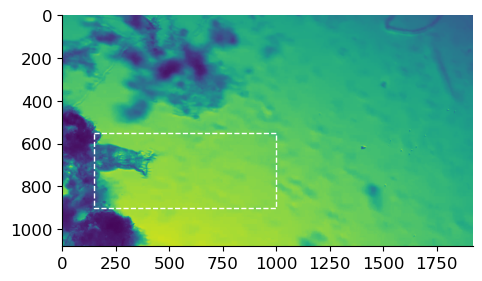

In [3]:
zoom_in = [150, 1000, 550, 900] 

plt.figure()
plt.imshow(frames[0])
plot_bbox(zoom_in)

In [4]:
# Read-in
img_fp = sorted([os.path.join(frames_filepaths, f) for f in os.listdir(frames_filepaths) if f.endswith(".jpg")])
cut_width, cut_height = zoom_in[1] - zoom_in[0], zoom_in[3] - zoom_in[2]
text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
video_save_fpath = f"./data/results/whirling/{vid_filename.split('.')[0]}_focus-corona-zoom-text.mp4"
vid_params = dict(filename=video_save_fpath, 
                  fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                  fps=fps, 
                  frameSize=(cut_width, cut_height), 
                  isColor=True)

SAVE_VIDEO = False
generate_video_with_text(vid_params, img_fp, text_params, bbox=zoom_in) if SAVE_VIDEO else None

In [5]:
from PIL import Image
zoom_in_pil = (150, 550, 1000, 900) # (left, upper, right, lower)

cut_frames = [[579,626], [4084,4137], [4689, 4727]]  # for food  capture
food_capture_dir = f"./data/images/{vid_filename.split('.')[0]}_food_capture_frames/"
os.makedirs(food_capture_dir, exist_ok=True)

SAVE_CUT = False
if SAVE_CUT:
    for cut in cut_frames:
        idx = np.arange(cut[0], cut[1])
        cut_imgs = [Image.open(img_fp[i]).crop(zoom_in_pil) for i in idx]
        des_fps = [os.path.join(food_capture_dir, os.path.basename(img_fp[i])) for i in idx]
        for img, des in zip(cut_imgs, des_fps):
            img.save(des)

In [6]:
SAVE_CAPTURE_VIDEO = False
if SAVE_CAPTURE_VIDEO:
    img_fp = sorted([os.path.join(food_capture_dir, f) for f in os.listdir(food_capture_dir) if f.endswith(".jpg")])
    cut_width, cut_height = zoom_in[1] - zoom_in[0], zoom_in[3] - zoom_in[2]
    text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0, color=(0,0,0), thickness=2)
    video_save_fpath = f"./data/results/whirling/{vid_filename.split('.')[0]}_food_capture.mp4"
    vid_params = dict(filename=video_save_fpath, 
                    fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                    fps=fps, 
                    frameSize=(cut_width, cut_height), 
                    isColor=True)

    generate_video_with_text(vid_params, img_fp, text_params, bbox=None) if SAVE_CAPTURE_VIDEO else None

## Extract some movement params

Index(['ids', 'fns', 'bbox', 'img_fp', 'cm'], dtype='object')
(0.66, 41.88)


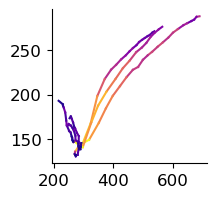

In [7]:
df = pd.read_csv("./data/csvs/metadata_food_capture.csv"); print(df.columns)
df["img_idx"] = [int(s[-1]) for s in df.fns.str.split("_")]
df = df.set_index("img_idx")
df["particle"] = None

for nth, cut in enumerate(cut_frames):
        idx = np.arange(cut[0], cut[1])
        df.loc[df.index.isin(idx), "particle"] = int(nth) + 1

df.drop(columns=["ids"], inplace=True)

# x and y pos
df["cm"] = df["cm"].apply(eval)  # tuples stored as strings, tranform back to tuples
df[["x", "y"]] = pd.DataFrame(df["cm"].to_list(), index=df.index)

# change of x and y
df["dx"] = df.groupby(by="particle")["x"].transform(lambda x: x.diff())
df["dy"] = df.groupby(by="particle")["y"].transform(lambda y: y.diff())
df["v"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)

# group according to particle
grouped = df.groupby("particle").apply(lambda x: x[["x", "y", "v"]].to_numpy())
groups = {category: {"x": values.T[0], "y": values.T[1], "v": values.T[2]} for category, values in grouped.items()}
prts = df.particle.unique()

global_vminmax = (round(df.v.min(),2), round(df.v.max(),2))
print(global_vminmax)

fig, ax = plt.subplots(figsize=(2,2))
for prt in prts:
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("plasma", argnotnan(v))
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax)


## Image stacks and min z-projection

In [33]:
first_img_fp = df.groupby("particle")["img_fp"].last().tolist()
#first_img_fp = df.groupby("particle")["img_fp"].first().tolist()
all_img_fp = df.groupby("particle")["img_fp"].apply(list)

zprojs = []
for prt in prts:
    image_stack = np.stack([cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in all_img_fp[prt]], axis=2, dtype="int16")
    first_img = image_stack[0]
    subtracted_stack = image_stack - first_img
    zprojs.append(np.min(subtracted_stack, axis=2))

zproj = np.min(np.stack(zprojs, axis=-1), axis=-1)
vmin, vmax = np.percentile(zproj, 1), 0

# plt.figure()
# plt.imshow(zproj, cmap="gray", vmin=vmin, vmax=vmax)

# fig, ax = plt.subplots(1,3,figsize=(18,3))
# for nth, zproj in enumerate(zprojs):
#     vmin, vmax = np.percentile(zproj, 1), 0
#     ax[nth].imshow(zproj, cmap="gray", vmin=vmin, vmax=vmax)
#     ax[nth].set(xlim=(50, 550), ylim=(50, 350)); ax[nth].invert_yaxis()
#     ax[nth].set_axis_off()

In [34]:
prts

array([1, 2, 3], dtype=object)

## Plotting

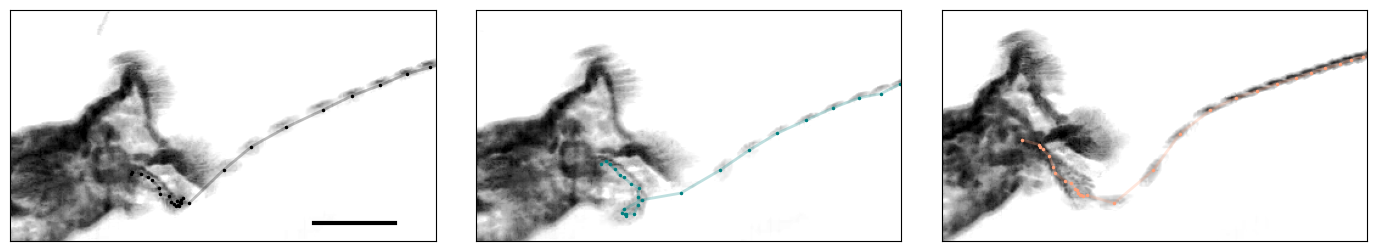

In [37]:
SAVE_FIGURES = False
ccols = ["lightsalmon", "teal", "k"]
ax_params = dict(xlim=(150,500), ylim=(110, 300), xticks=[],yticks=[])
prts_ = np.array([3,2,1])  # np.fliplr

fig, ax = plt.subplots(1,3,figsize=(18, 3), gridspec_kw={"wspace" : .005})
for nth, prt in enumerate(prts_):
    # Image
    vmin, vmax = np.percentile(zprojs[prt-1], .1), 0
    ax[nth].imshow(zprojs[prt-1], cmap="gray", vmin=vmin, vmax=vmax)
    img_fp = df.groupby("particle")["img_fp"].first().tolist()[prt-1]
    
    
    # Plot
    x, y = groups[prt]["x"], groups[prt]["y"]
    ax[nth].plot(x, y, ".", lw=2, ms=3, color=ccols[prt-1], alpha=1)
    ax[nth].plot(x, y, "-", lw=2, color=ccols[prt-1], alpha=.25)
    
    # Axes
    ax[nth].set(**ax_params)
    #ax[nth].invert_yaxis();
    for spine in ax[nth].spines.values():
        spine.set_visible(True)

plot_scalebar(ax=ax[0], mpp=mpp, width_microns=50, position=(400, 125), linewidth=3, fontsize=None)
fig.savefig(f"{results_save_path}food_particle_capture_zmin-project_update.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

## Plot color-coded particle trajectories
- load masks in first

In [38]:
df_stats = get_contour_stats(contour_list)
df_stats
len(contour_list)

3

In [39]:
del contour_list

[(112, 166), (141, 144), (141, 142)]


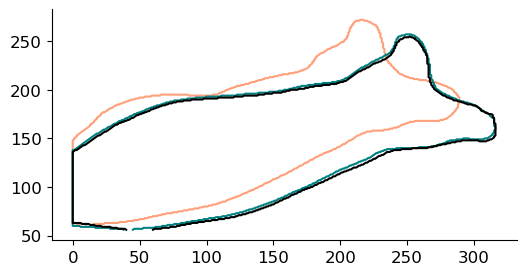

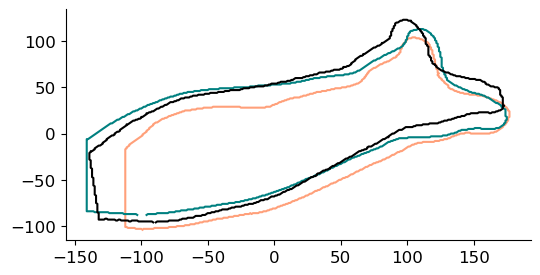

In [48]:
# load masks of first images
first_frames = df.reset_index().drop_duplicates(subset='particle', keep='last').index.values
#first_frames = df.reset_index().drop_duplicates(subset='particle', keep='first').index.values
mask_dir = "./data/seg_masks/2024_0323_075154_003_food_capture_masks/"
mask_fps = [f for f in sorted(os.listdir(mask_dir))]
mask_fp = [os.path.join(mask_dir, mask_fps[ff]) for ff in first_frames]
contour_list = get_contours_from_segmasks(mask_fp)
df_stats = get_contour_stats(contour_list)
idx=0
df_stats.loc[idx,"centroid_x"] = df_stats.loc[idx,"centroid_x"] - 14
df_stats.loc[idx,"centroid_y"] = df_stats.loc[idx,"centroid_y"] + 11

centers = list(df_stats[["centroid_x", "centroid_y"]].itertuples(index=False, name=None))
print(centers)
rot_angles = [.7, 0, -6]
rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, mask_fp)
centered_contours = normalize_contours_by_centers(rot_contours, centers) 
x,y =df_stats[["centroid_x", "centroid_y"]].mean().values

plt.figure()
for nth, cnt in enumerate(contour_list):
    cnt = np.squeeze(cnt)
    plt.plot(cnt[:,0], cnt[:,1], color=ccols[nth])

plt.figure()
for nth, cnt in enumerate(centered_contours):
    cnt = np.squeeze(cnt)
    plt.plot(cnt[:,0], cnt[:,1], color=ccols[nth])

29.578087466910137 1884.9740539551444


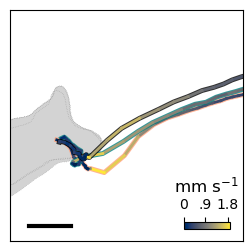

In [57]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
SAVE_FIGURES = False
normalize = True
ax_params = dict(xlim=(30,400), ylim=(-50,150), xticks=[], yticks=[])
prts = df.particle.unique()
#prts = prts[::-1]

fig, ax = plt.subplots(figsize=(3,3))
for nth, cnt in enumerate(contour_list):
    cnt = np.squeeze(cnt.copy())
    if normalize:
        cnt[:,0] = cnt[:,0] - df_stats.loc[nth, "centroid_x"]
        cnt[:,1] = cnt[:,1] - df_stats.loc[nth, "centroid_y"]
    ax.fill_between(cnt[:,0], cnt[:,1], facecolor="lightgray")  #, lw=1, edgecolor="gray", linestyle="--")
    ax.plot(cnt[:,0], cnt[:,1], ":", color="gray", alpha=.5, lw=.5)


for nth, prt in enumerate(prts):
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("cividis", argnotnan(v), global_vminmax)
    if normalize:
        x = x - df_stats.loc[nth, "centroid_x"]
        y = y - df_stats.loc[nth, "centroid_y"]
    #ax.plot(x[1:], y[1:], "-", lw=3, color="gray", alpha=.5)
    ax.plot(x[1:], y[1:], "-", lw=3.5, color=ccols[prt-1], alpha=.8)
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax, lw=2)
    
ax.set_aspect('equal', adjustable='datalim'); ax.set(**ax_params);


vvals = df.v.values / mpp * fps
print(np.nanmin(vvals), np.nanmax(vvals))
# colorbar as inset axes
_, sm = create_scalarmappable("cividis", argnotnan(df.v.values), vminmax=global_vminmax)
axin = inset_axes(ax, width="20%", height="3%", loc="lower right", borderpad=.75)
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0.66, 20, 40])
cbar.set_ticklabels(["0", ".9", "1.8"], fontsize=10)

cbar.set_label("mm s$^{-1}$", fontsize=12)
axin.xaxis.set_ticks_position("top")
axin.xaxis.set_label_position("top")
set_spines_visible(ax=ax)
plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(60, -110), linewidth=3, fontsize=None)
fig.savefig(f"{results_save_path}food_particle_captured_trajectories_with_mask_datalim_update.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

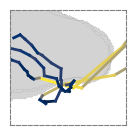

In [50]:
# Zoom in
near_ax_params = dict(xlim=(110, 185), ylim=(-25,50), xticks=[], yticks=[])
bbox_ = [230,350,125,180]

fig, ax = plt.subplots(figsize=(1.5,1.5))# , aspect_ratio="auto"
for nth, cnt in enumerate(contour_list):
    cnt = np.squeeze(cnt.copy())
    if normalize:
        cnt[:,0] = cnt[:,0] - df_stats.loc[nth, "centroid_x"]
        cnt[:,1] = cnt[:,1] - df_stats.loc[nth, "centroid_y"]
    ax.fill_between(cnt[:,0], cnt[:,1], facecolor="lightgray")
    ax.plot(cnt[:,0], cnt[:,1], ":", color="gray", alpha=.5, lw=.5)
    
    
for prt in prts:#[::-1]:
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("cividis", argnotnan(v), vminmax=global_vminmax)  # PuRd, cividis
    if normalize:
            x = x - df_stats.loc[nth, "centroid_x"]
            y = y - df_stats.loc[nth, "centroid_y"]
    #ax.plot(x[1:], y[1:], "-", lw=2, color="gray", alpha=.5)
    #ax.plot(x[1:], y[1:], "-", lw=2.5, color=ccols[prt-1], alpha=.8)
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax, lw=2)

set_spines_visible(ax=ax, color="gray", ls="--")
ax.set(**near_ax_params);
ax.set_aspect('equal', adjustable='datalim')
fig.savefig(f"{results_save_path}food_particle_captured_trajectories_with_mask_zoom-in.jpg", dpi=600, bbox_inches="tight", edgecolor=None)# if SAVE_FIGURES else None

(0.66, 41.88)


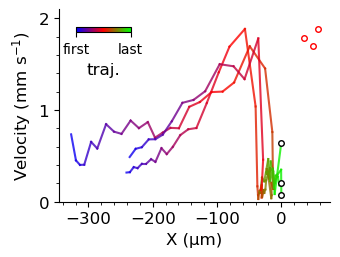

In [51]:
print(global_vminmax)
fig, ax = plt.subplots(figsize=(3.5,2.5))

for nth, prt in enumerate(prts):
    x, v = groups[prt]["x"] * -1, groups[prt]["v"]
    if normalize:
        x = x - df_stats.loc[nth, "centroid_x"]
        x = x - x[-1]
    #ax.plot(x / mpp, v, "-", lw=1.5, color=ccols[prt-1], alpha=.8)
    c_, _ = create_scalarmappable("brg", np.arange(0, len(x)))
    plot_colorline(x / mpp, v / mpp * fps / 1000, colors=c_, alpha=.8)

for nth, prt in enumerate(prts):
    x, v = groups[prt]["x"], groups[prt]["v"]
    if normalize:
        x = x - df_stats.loc[nth, "centroid_x"]
        x = x - x[-1]
    ax.plot(x[np.where(v==np.nanmax(v))[0][0]] / mpp, np.nanmax(v) / mpp * fps / 1000, "o", mfc="w", ms=4, color="r")
    ax.plot(x[-1] / mpp, v[-1] / mpp * fps / 1000, "o", mfc="w", ms=4, color="k")
    #ax.plot(x[1] / mpp, v[1], "o", mfc="w", ms=4, color=ccols[prt-1])

_, sm = create_scalarmappable("brg", np.arange(0,51))
axin = inset_axes(ax, width="20%", height="3%", loc="upper left", borderpad=1.05)
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, 50])
cbar.set_ticklabels(["first", "last"], fontsize=10)

cbar.set_label("traj.", fontsize=12)
axin.xaxis.set_ticks_position("bottom")
axin.xaxis.set_label_position("bottom")

ax.set(xlabel=("X (µm)"), ylabel=("Velocity (mm s$^{-1}$)"), ylim=(0,2.1), yticks=(0,1,2));
ax.minorticks_on()
#fig.savefig(f"{results_save_path}food_particle_captured_trajectories_against_X.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

[(-200.0, 200.0)]

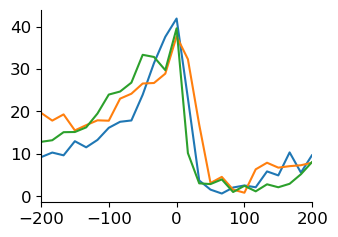

In [29]:
normalized_data = []

for prt in prts:
    v = groups[prt]["v"]
    v_non_nan = v[~np.isnan(v)]#v.dropna().values
    ctime = np.arange(len(v_non_nan))
    idx_max = np.argmax(v_non_nan)
    timeidx = ctime[idx_max]
    
    # Normalize time
    norm_time = (ctime - timeidx) / fps * 1000
    normalized_data.append((norm_time, v_non_nan))

fig, ax = plt.subplots(figsize=(3.5,2.5))

for t, v in normalized_data:
    ax.plot(t, v)

ax.set(xlim=(-200, 200))

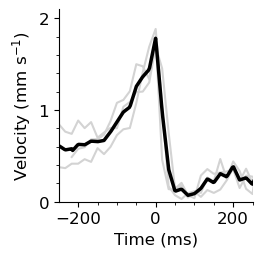

In [33]:
from scipy.interpolate import interp1d

all_times = np.concatenate([t for t, _ in normalized_data])
common_time = np.linspace(all_times.min(), all_times.max(), num=250)  # Adjust the number of points as needed

# Interpolate signals to common time
interpolated_signals = []

for t, v in normalized_data:
    interpolator = interp1d(t, v, bounds_error=False, fill_value=np.nan)
    interpolated_signal = interpolator(common_time)
    interpolated_signals.append(interpolated_signal)

# Convert to DataFrame for easier manipulation
interpolated_df = pd.DataFrame(interpolated_signals).T
interpolated_df.columns = prts

# Compute the mean signal, ignoring NaNs
mean_signal = interpolated_df.mean(axis=1, skipna=True)

fig, ax = plt.subplots(figsize=(2.5,2.5))

for t, v in normalized_data:
    ax.plot(t, v / mpp * fps / 1000, lw=1.5, color="lightgray")  # Plot original signals with some transparency

ax.plot(common_time, mean_signal / mpp * fps / 1000, color="k", linewidth=2.5, label='Mean Signal')
ax.set(xlabel=("Time (ms)"), ylabel=("Velocity (mm s$^{-1}$)"), ylim=(0,2.1), yticks=(0,1,2), xlim=(-250, 250));
ax.minorticks_on()
#ig.savefig(f"{results_save_path}food_particle_captured_trajectories_against_time_aligned_to_maxV.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

In [ ]:
# SAVE_FIGURES = False

# # NEED TO ADJUST THE SPEED / VELOCITY

# print(df.v.min(), df.v.max())
# near_ax_params = dict(xlim=(230,350), ylim=(125,180), xticks=[], yticks=[])
# bbox_ = [230,350,125,180]
# far_ax_params = ax_params

# cnt = np.squeeze(contour_list[2])

# fig, ax = plt.subplots()
# ax.fill_between(cnt[:,0], cnt[:,1], ":", color="lightgray", lw=1)

# for prt in prts:
#     x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
#     c_, _ = create_scalarmappable("cividis", argnotnan(v), vminmax=(0, 42))  # PuRd, cividis
#     ax.plot(x[1:], y[1:], "-", lw=6, color=ccols[prt-1], alpha=.8)
#     plot_colorline(x[1:], y[1:], colors=c_, ax=ax, lw=4, alpha=1)
    
# plot_bbox(bbox_, c="gray", ax=ax)
# set_spines_visible(ax=ax)
# ax.set(**far_ax_params);
# plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(400, 125), linewidth=3, fontsize=1)

# #ax.invert_yaxis()

# # colorbar as inset axes
# _, sm = create_scalarmappable("cividis", argnotnan(df.v.values), vminmax=(0, 42))
# axin = inset_axes(ax, width="15%", height="3%", loc="lower left", borderpad=1)
# cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, 20, 40])
# cbar.set_label("µm s$^{-1}$", fontsize=12)
# axin.xaxis.set_ticks_position("top")
# axin.xaxis.set_label_position("top")
# fig.savefig(f"{results_save_path}food_particle_captured_trajectories_with_mask.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

# # Zoom in
# fig, ax = plt.subplots(figsize=(1.5,.75))
# ax.fill_between(cnt[:,0], cnt[:,1], ":", color="lightgray", lw=1)

# for prt in prts:#[::-1]:
#     x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
#     c_, _ = create_scalarmappable("cividis", argnotnan(v), vminmax=(0, 42))  # PuRd, cividis
#     #ax.plot(x[1:], y[1:], "-", lw=6, color=ccols[prt-1], alpha=.8)
#     plot_colorline(x[1:], y[1:], colors=c_, ax=ax, lw=3, alpha=1)

# set_spines_visible(ax=ax, color="gray", ls="--")
# ax.set(**near_ax_params);

# #### DO NOT INVERT
# #ax.invert_yaxis()

# fig.savefig(f"{results_save_path}food_particle_captured_trajectories_with_mask_zoom-in.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

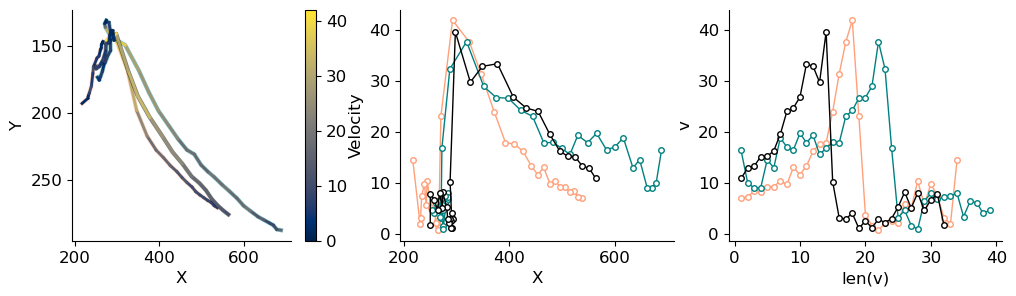

In [31]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

for prt in prts:
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("cividis", argnotnan(v), vminmax=(0, 42))  # PuRd, cividis
    ax[0].plot(x[1:], y[1:], "-", lw=3, color=ccols[prt-1], alpha=.5)
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax[0], lw=2)
    
ax[0].invert_yaxis()
ax[0].set(xlabel=("X"), ylabel=("Y"));
_, sm = create_scalarmappable("cividis", argnotnan(df.v.values), vminmax=(0, 42))
fig.colorbar(sm, ax=ax[0])

for prt in prts:
    x, v = groups[prt]["x"], groups[prt]["v"]
    ax[1].plot(x, v, "-o", lw=1, mfc="w", ms=4, color=ccols[prt-1])
ax[1].set(xlabel=("X"), ylabel=("Velocity"));

for prt in prts:
    v = groups[prt]["v"]
    ax[2].plot(np.arange(len(v)), v, "-o", lw=1, mfc="w", ms=4, color=ccols[prt-1])
ax[2].set(xlabel=("len(v)"), ylabel=("v"));

In [ ]:
time = np.linspace(0, num_frames / fps, num_frames)
tmax = max(time)

tpoint1 = np.where(time <= 83)[0][-1] 
tvec = np.where((time >= 68) & (time <= 72))[0]

print("tpoints 1 frames=", tpoint1, "tvec", len(tvec))

## Locate features for single frame

In [ ]:
diameter = 27#13
threshold = 5#15
frame_nr = tvec[1]

# Location of features
f = tp.locate(frames[frame_nr], diameter, invert=True, threshold=threshold, maxsize=7)
print(len(f))
f.head(5)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
tp.annotate(f, frames[frame_nr], ax=ax[0], plot_style={"markersize" : 10});
tp.annotate(f, frames[frame_nr], ax=ax[1], plot_style={"markersize" : 10});
ax[1].set(xlim=(1350, 1500), ylim=(580, 750)); ax[1].invert_yaxis()

fig, ax = plt.subplots(1, 2, figsize=(10,10))
tp.annotate(f, frames[frame_nr+5], ax=ax[0], split_thresh=10, plot_style={"markersize" : 10});
tp.annotate(f, frames[frame_nr+5], ax=ax[1], plot_style={"markersize" : 10});
ax[1].set(xlim=(1350, 1500), ylim=(580, 750)); ax[1].invert_yaxis()


# 2. Batch Process frames

In [ ]:
tp.quiet()
f = tp.batch(frames[:tpoint1], diameter, invert=True, threshold=threshold, maxsize=7)
#f = tp.batch(frames[tvec], diameter, invert=True, threshold=threshold, maxsize=7)
print(len(f))

### Plot some of the parameters of detected particels

In [ ]:
params = ["mass", "size", "ecc", "signal", "raw_mass", "ep"]

fig, ax = plt.subplots(1, 6, figsize=(19,2.5))
for nth, param in enumerate(params):
    ax[nth].hist(f[param], bins=100)
    ax[nth].set(xlabel=param, ylabel='count');

In [ ]:
#fbatch = f[f.signal > 40]

# 3. Link particles / frames to trajectories

In [ ]:
tp.quiet()
max_displacement = 30  # in px
particle_memory = 7
t = tp.link(f, max_displacement, memory=particle_memory, adaptive_stop=10, adaptive_step=.95)
print('num_trajectories', t['particle'].nunique())
t.head()

# 4. Trajectories

## Filtering based on number of frames

In [ ]:
lasts_num_frames = 10
t1 = tp.filter_stubs(t, lasts_num_frames)
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())
#t1.to_csv(f"./data/results/vortex/{vid_filename.split('.')[0]}_traj.csv")

In [ ]:
### Trajectory stats
ctraj = t1
stats, frames_present = get_trajectory_stats(ctraj)
stats.head(10)
# This plots trajectories with associated particle number
fig, ax = plt.subplots(figsize=(17,17))
tp.plot_traj(ctraj, superimpose=frames[frame_nr], label=True, ax=ax);

fig, ax = plt.subplots(1, 2, figsize=(10,5))
tp.scatter(ctraj, ax=ax[0], plot_style={"ms" : 2, "alpha" : .1, "color" : "k", "label" : "accepted"})
tp.scatter(ctraj, ax=ax[1], plot_style={"ms" : 2, "alpha" : .1, "color" : "k", "label" : "accepted"})
ax[1].set(xlim=(200, 1050), ylim=(600, 850)); ax[1].invert_yaxis()

In [ ]:
prts = [15, 55]
ctraj[ctraj.particle==15]
ctraj[ctraj.particle==57]

In [ ]:
# num_frames = len(frames)
# subtract_frame_idx = 0
# frame_step = 12
# subtract_frame = frames[subtract_frame_idx]
# process_frames = np.arange(subtract_frame_idx + 1, tpoint1, step=frame_step)

# zproj = []
# for nth in process_frames:
#     zproj.append(frames[nth] - subtract_frame)

# zproj = np.stack(zproj)
# zproj = np.min(zproj, axis=0)
# print(np.min(zproj))

In [ ]:
vmin_ = np.min(zproj) #+ 90
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=0)
fig.savefig(f"./data/results/vortex/{vid_filename.split('.')[0]}-zmin-proj_num_process_frames{process_frames[-1]}_frame-step{frame_step}_vmin{vmin_}.jpg", dpi=600)

In [ ]:
SAVE_NPY = True
if SAVE_NPY:
    np.save(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy", zproj)
else:
    zproj = np.load(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy")


# reject trajectories

In [ ]:
stats, frames_present = get_trajectory_stats(t1)
ctraj = t1

# rejection conditions
reject_idx = (stats.x_std < 30) & (stats.y_std < 30) #& (stats.displacement_first_last < 70)
reject_prts = stats.particle[reject_idx].to_numpy()
reject_prts = np.append(reject_prts, [56, 81]) 
reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(ctraj["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = ctraj.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

particles = ctraj.particle.unique()
particles_rejected = traj_rejected.particle.unique()
print("number of particle trajectories:", len(particles))
print("number of rejected particle trajectories:", len(particles_rejected))
# further particels to reject 81, 56

## Visualize Trajectories

In [ ]:
# This plots trajectories with associated particle number
fig, ax = plt.subplots(figsize=(25,25))
tp.plot_traj(ctraj, superimpose=frames[frame_nr], label=True, ax=ax);

frame_nr = 0

fig, ax = plt.subplots(figsize=(10,5))
tp.scatter(ctraj, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k", "label" : "accepted"})
tp.scatter(traj_rejected, ax=ax, plot_style={"ms" : 2, "alpha" : .5, "color" : "r", "label" : "rejected"})
ax.legend()

## recalculate stats

In [ ]:
stats, frames_present = get_trajectory_stats(ctraj)
stats.head(10)

# Velocity field calculation

In [ ]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

particles = ctraj.particle.unique()

df = pd.DataFrame()
for nth in particles:#is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    d = {
        "x" : traj.x.to_list(),
        "y" : traj.y.to_list(),
        "dx" : traj.x.diff().to_list(),
        "dy" : traj.y.diff().to_list()
    }
    # have to interpolate so that there are no jumps in velocity across frames
    df_loop = pd.DataFrame(d)
    df = pd.concat([df, df_loop[1:]])

df#_loop
# Generate some sample data (replace this with your actual data)

points = df[["x", "y"]].to_numpy()
print(points.shape)
velocities = df[["dx", "dy"]].to_numpy()

# # Define grid for velocity field
grid_x, grid_y = np.meshgrid(np.linspace(0, img_width, img_width), np.linspace(0, img_height, img_height))

# # Interpolate velocities onto grid
grid_u = griddata(points, velocities[:, 0], (grid_x, grid_y), method='linear')
grid_v = griddata(points, velocities[:, 1], (grid_x, grid_y), method='linear')


In [ ]:
np.diff(grid_x[0,:2])
#np.diff(grid_y[:2,0])

In [ ]:
# import numpy as np

# def cartesian_to_polar(x, y):
#     r = np.sqrt(x**2 + y**2)
#     theta = np.arctan2(y, x)
#     return r, theta

# def radial_speed(x, y, vx, vy):
#     # Convert Cartesian coordinates to polar coordinates
#     r, theta = cartesian_to_polar(x, y)
#     # Calculate radial speed
#     v_radial = (x*vx + y*vy) / r    
#     return v_radial

# x = np.array([1, 2, 3])  # Example x coordinates
# y = np.array([4, 5, 6])  # Example y coordinates
# vx = np.array([0.1, 0.2, 0.3])  # Example x velocities
# vy = np.array([0.2, 0.3, 0.4])  # Example y velocities

# # Calculate radial speed for each particle
# v_radial = radial_speed(x, y, vx, vy)

# print("Radial speeds:", v_radial)

def vorticity_from_velocity(dx, dy, u, v):
    dudy = np.gradient(u, axis=0) / dy
    dvdx = np.gradient(v, axis=1) / dx
    return dvdx - dudy

dx = np.diff(grid_x[0, :])[0]
dy = np.diff(grid_y[:, 0])[0]

print(dy)
omega = vorticity_from_velocity(dx, dy, grid_u, grid_v)
omega
(~np.isnan(omega)).sum()

In [ ]:
np.nanmin(omega)
np.nanmax(omega)

In [ ]:
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(omega, vmin=-3,vmax=3, cmap="PuOr", alpha=.8)

In [ ]:
# def vorticity(Vx, Vy, x, y):
#     # Calculate partial derivatives
#     dVy_dx = np.gradient(Vy, x, axis=1)
#     dVx_dy = np.gradient(Vx, y, axis=0)
    
#     # Calculate vorticity
#     omega = dVy_dx - dVx_dy
    
#     return omega

# omega = vorticity(velocities[:,0], velocities[:,1], points[:,0], points[:,1])
# omega

In [ ]:
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(grid_v, cmap="PuOr", alpha=.8)

In [ ]:
speed = np.sqrt(grid_v ** 2 + grid_u ** 2)
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(speed, cmap="jet", alpha=.8)

In [ ]:
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(grid_u, cmap="jet", alpha=.8)

plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(grid_v, cmap="jet", alpha=.8)

speed = np.sqrt(grid_v ** 2 + grid_u ** 2)
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(speed, cmap="jet", alpha=.8)

In [ ]:
plt.figure()
plt.streamplot(grid_x, grid_y, grid_u, grid_v, color=speed) # , density=1broken_streamlines=False, linewidth=20*speed / speed.max()
plt.gca().invert_yaxis()

In [ ]:
plt.figure()
plt.streamplot(grid_x, grid_y, grid_u, grid_v, color=speed) # , density=1broken_streamlines=False, linewidth=20*speed / speed.max()
plt.gca().invert_yaxis()

In [ ]:
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(speed, cmap="BuPu", alpha=.8)
plt.streamplot(grid_x, grid_y, grid_u, grid_v, color="k") # linewidth=20*speed / speed.max()
plt.gca().invert_yaxis()

In [ ]:
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(speed, cmap="BuPu", alpha=.8)
plt.streamplot(grid_x, grid_y, grid_u, grid_v, color="k") # linewidth=20*speed / speed.max()
plt.gca().invert_yaxis()

### Plot valid trajectories

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(17, 4))
tp.plot_traj(ctraj, superimpose=frames[frame_nr], ax=ax[0], plot_style={"color": "k", "lw" : 1, "alpha" : .5});
tp.annotate(ctraj[ctraj.frame == frame_nr], frames[frame_nr], ax=ax[0], plot_style={"markersize" : 7, "markeredgewidth" : 1});  # this shows the bandpass filtered image
ax[0].plot([1275, 1425, 1425, 1275, 1275], [550, 550, 700, 700, 550], "--w", lw=1)
ax[0].set_xlim(0, img_width)

#bbox = [1275, 1425, 550, 700]
tp.annotate(ctraj[ctraj.frame == frame_nr], frames[frame_nr], ax=ax[1], plot_style={"markersize" : 25, "markeredgewidth" : 2});  # this shows the bandpass filtered image
ax[1].set_xlim(1275, 1425); ax[1].set_ylim(550, 700); ax[1].invert_yaxis()
ax[1].axis("off")

#fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-annotated.jpg", dpi=600)

## Plot selected particles with time color code

- load Max/Min Z projection of all Frames

In [ ]:
zproj_min = np.load("./data/results/vortex/trajectories_zmin-proj-tpoint2.npy")
# zproj_norm = (zproj_min) / (zproj_min.min() * -1)
# print(zproj_norm.min(), zproj_norm.max())
# fig, ax = plt.subplots(1,2,figsize=(17, 4))
# ax[0].imshow(zproj_norm, cmap="gray")
# ax[1].imshow(zproj_min, cmap="gray")

# for velocity > random selection of particles

In [ ]:
indices = stats.travel_dist.sort_values(ascending=False)[:10].index.values
selected_prts = sorted(stats.loc[indices, "particle"].to_numpy())
selected_prts
particles = ctraj.particle.unique()
dsize=[]
for nth, pt in enumerate(particles):  # selected_prts
    straj = ctraj.loc[ctraj["particle"] == pt]
    dsize.append(tp.diagonal_size(straj))

plt.hist(dsize, bins=15);

In [ ]:
center_x_line = [1320, 730]
center_y_line = [0, img_height]
x_line = [700, img_width]
y_line = [0, 680]

fig, ax = plt.subplots(figsize=(17, 4))
ax.imshow(zproj_min, cmap="gray")
# ax.plot(center_x_line, center_y_line, "-k", alpha=.8, lw=.5)
# ax.plot(x_line, y_line, "-k", alpha=.8, lw=.5)
ccmap = mpl.cm.brg
prts = [288,107,490, 285] # 7,18 prts = [90, 490, 285, 445]
for nth, pt in enumerate(prts):
    traj = ctraj.loc[ctraj["particle"] == pt]
    tp.plot_traj(traj, ax=ax, colorby="frame", cmap=ccmap, label=False, plot_style={"linewidths" : 2});

ax.set_xlim(500, img_width); ax.set_ylim(0, img_height)
ax.invert_yaxis()
#fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-frame.jpg", dpi=600)

### select continuous

In [ ]:
is_continuous = list()
for nth, row in stats.iterrows():
    clist = row["frames_present"]
    if all(np.diff(clist)<=2): #any(np.diff(clist)>=2):
        is_continuous.append(nth)

len(is_continuous)

In [ ]:
minmax = []
cmap = plt.cm.jet
fig, ax = plt.subplots(figsize=(17,4))
ax.imshow(frames[frame_nr], cmap="gray")
# or only continuous traj, w/o frame jump, or of different diag-size
for nth in is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        x = traj.x.to_numpy()
        y = traj.y.to_numpy()

        dx = traj.x.diff()
        dy = traj.y.diff()
        dist = np.sqrt(dx ** 2 + dy ** 2)

        vector = dist.to_numpy()[1:]
        minmax.append([vector.min(), vector.max()])
        norm = plt.Normalize(0, 35)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=1, alpha=1)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()

ax.set_xlim(800,1600); ax.set_ylim(0,800)
ax.invert_yaxis()
#fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-displacement.jpg", dpi=600)

In [ ]:
minmax_ = np.array(minmax)
minmax_.shape
print(minmax_.min(), minmax_.max())

### Position change
- loop through the points to color frames by velocity or global frame nr


In [ ]:
prts = [7,18,90,445,288,107,490, 285] # 7,18 prts = [90, 490, 285, 445]
# fig, ax = plt.subplots(len(prts), 1, figsize=(17,20))
# for nth, pt in enumerate(prts):
#     traj = ctraj.loc[ctraj["particle"] == pt]
#     xm = traj.x.diff().rolling(window=5).mean()
#     ym = traj.y.diff().rolling(window=5).mean()
#     dist = np.sqrt(xm ** 2 + ym ** 2)
#     tx = traj.frame.rolling(window=5).mean()

#     ax[nth].plot(tx, dist, "-b", label=f"particle {str(pt)}")
#     ax[nth].set_title(str(pt))
    
prts = [7, 107, 445]
prt_colors = ["k", "grey", "b"]
fig, ax = plt.subplots(figsize=(5,4))

for nth, pt in enumerate(prts):
    traj = ctraj.loc[ctraj["particle"] == pt]
    xm = traj.x.diff().rolling(window=5).mean()
    ym = traj.y.diff().rolling(window=5).mean()
    dist = (np.sqrt(xm ** 2 + ym ** 2) * .61) * 60 
    tx = traj.frame.rolling(window=5).mean()
    tx = (tx - 1800) / 60
    ax.plot(tx, dist / 1000, "-", lw=2, color=prt_colors[nth], label=f"particle {str(pt)}")

ax.set_xlabel("Time (sec)"); ax.set_ylabel("Particle velocity (mm / sec)")
ax.set_ylim(0, 1.25)
ax.legend()
plt.tight_layout()
fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-displacement-timeseries.jpg", dpi=600)

In [ ]:
cmap = plt.cm.jet
fig, ax = plt.subplots(figsize=(5,4))
for nth, pt in enumerate(prts):
    traj = ctraj.loc[ctraj["particle"] == pt]
    if not traj.empty:
        x = traj.x.to_numpy()
        y = traj.y.to_numpy()

        dx = traj.x.diff()
        dy = traj.y.diff()
        dist = np.sqrt(dx ** 2 + dy ** 2)

        vector = dist.to_numpy()[1:]
        minmax.append([vector.min(), vector.max()])
        norm = plt.Normalize(0, 35)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=2, alpha=1)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()
        
        ax.plot(x[0], y[0], "o", ms=8, mec=prt_colors[nth], mfc=prt_colors[nth], label=f"particle {str(pt)}")
        ax.plot(x[-1], y[-1], "o", ms=3, mec=prt_colors[nth], mfc=prt_colors[nth])
        

ax.set_xlim(500, img_width); ax.set_ylim(0,img_height + 20)
ax.set_xlabel("x (px)"); ax.set_ylabel("y (px)")
ax.invert_yaxis()
plt.tight_layout()

fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-displacement-selected-only.jpg", dpi=600)

### trajectory params

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.particle, stats.ep_median, ".k", alpha=.6)
ax[0].set_ylim(-2.5, 2.5); ax[0].set_xlabel("particle");

ax[1].plot(stats.particle, stats.first_frame, "*r", ms=3, alpha=.6, label="first frame")
ax[1].plot(stats.particle, stats.last_frame, "sk", ms=3, alpha=.6, label="last frame")
ax[1].plot(stats.particle, stats.nframes, "ob", ms=3, alpha=.6, label="number of frames")
ax[1].set_xlabel("particle");
ax[1].legend()

ax[2].hist(stats.travel_dist, bins=150, color="k");
ax[2].set_xlabel("travel distance per particle (pixels)");
ax[2].set_ylabel("Count"); #ax[2].set_xlim(0, 1500);


fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].hist(frames_present / 60, bins=100, density=True, color="k");
ax[0].set_xlabel("frames"); ax[0].set_ylabel("Norm. trajectory particle count");
ax[0].set_ylim(0, .15); #ax[0].set_xlim(0, 1050);


ax[1].hist(stats.nframes, bins=100, color="k");
ax[1].set_xlabel("Number of frames per trajectory")
#ax[1].set_xlim(0, 300);

fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.nframes, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[0].set_xlabel("N frames"); ax[0].set_ylabel("Dist 1st to last frame")

ax[1].plot(stats.nframes, stats.travel_dist, "ko", ms=3, alpha=.6)
ax[1].set_xlabel("N frames"); ax[1].set_ylabel("Path traveled")

ax[2].plot(stats.travel_dist, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[2].set_xlabel("Path traveled"); ax[2].set_ylabel("Dist 1st to last frame");

## Inspect all trajectories

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
tp.scatter(ctraj, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k"})
ax.set_xlim(1000, 1400); ax.set_ylim(0, 400)
ax.invert_yaxis()

## Trajectory selection

In [ ]:
# # RIGHT
# cxlim = [1300, 1800]
# cylim = [300, 1000]
# bool_idx_r = (stats.x_avg > cxlim[0]) & (stats.y_avg > cylim[0]) & (stats.nframes > 40) & (stats.nframes < 180)
# print(sum(bool_idx_r))
# stats.loc[bool_idx_r, :]
# selected_particle_trajs_r = sorted([28,90,243,244,400,490])
# bool_idx2_r = stats.particle.isin(selected_particle_trajs_r)
# right_selected = [90, 490] # 400, 
# #stats.loc[bool_idx2, :]
# yxlim = frames[0].shape
# ccmap = mpl.cm.brg

# prts = stats.loc[bool_idx2_r, "particle"]
# colors = [ccmap(i)[:3] for i in np.linspace(0, 1, len(prts))]

# fig, ax = plt.subplots(len(prts), 1, figsize=(7,50))
# for nth, pt in enumerate(prts):
#     traj = ctraj.loc[ctraj["particle"] == pt]
#     tp.plot_traj(traj, ax=ax[nth], colorby="frame", cmap=ccmap, label=False);
#     #ax[nth].set_xlim(cxlim); ax[nth].set_ylim(cylim)
#     ax[nth].set_title(str(pt))
#     ax[nth].invert_yaxis()



In [ ]:
# cxlim = [800, 1100]
# cylim = [0, 400]
# bool_idx = (stats.x_avg < cxlim[1]) & (stats.y_avg < cylim[1]) #& (stats.nframes > 40) & (stats.nframes < 80)
# print(sum(bool_idx))
# #stats.loc[bool_idx, :]
# selected_particle_trajs = sorted([445,386,354,285,191])
# bool_idx2 = stats.particle.isin(selected_particle_trajs)
# stats.loc[bool_idx2, :]

In [ ]:
# yxlim = frames[0].shape
# ccmap = mpl.cm.brg

# prts = stats.loc[bool_idx2, "particle"]
# left_selected = [285, 445]
# colors = [ccmap(i)[:3] for i in np.linspace(0, 1, len(prts))]

# fig, ax = plt.subplots(len(prts), 1, figsize=(7,20))
# for nth, pt in enumerate(prts):
#     traj = ctraj.loc[ctraj["particle"] == pt]
#     tp.plot_traj(traj, ax=ax[nth], colorby="frame", cmap=ccmap, label=False);
#     ax[nth].set_xlim(cxlim); ax[nth].set_ylim(cylim)
#     ax[nth].set_title(str(pt))
#     ax[nth].invert_yaxis()

## Single trajectory and Max/Min Z projection of Frames

In [ ]:
indices = stats.travel_dist.sort_values(ascending=False)[:10].index.values
selected_prts = sorted(stats.loc[indices, "particle"].to_numpy())
selected_prts

In [ ]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.imshow(zproj_min, cmap="gray")

for prt in selected_prts:
    traj = ctraj.loc[ctraj["particle"] == prt] # 7,16
    prt_frames = traj["frame"].unique()
    x = traj.x.to_numpy()
    y = traj.y.to_numpy()
    
    ax.plot(x, y, "-k", lw=.5)
    ax.plot(x[::20], y[::20], "ok", mfc="w")
    ax.plot(x[0], y[0], "ob", mfc = "b", label="start", ms=10)
    ax.plot(x[-1], y[-1], "ob", mfc = "r", label="end", ms=10)
ax.set_xlim(500, 1800);

In [ ]:
# have to do this with arrows, < and > do not cover it
traj = ctraj.loc[ctraj["particle"] == 354] # 7,16,9
prt_frames = traj["frame"].unique()
x = traj.x.to_numpy()
y = traj.y.to_numpy()

fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.imshow(zproj_min, cmap="gray")
ax.plot(x, y, "-k", lw=.5)
ax.plot(x[::20], y[::20], "ok", mfc="w")
ax.plot(x[0], y[0], "ob", mfc = "b", label="start", ms=10)
ax.plot(x[-1], y[-1], "ob", mfc = "r", label="end", ms=10)
ax.set_xlim(500, 1800); #ax.set_ylim(0, 700)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
tp.plot_traj(traj, superimpose=frames[frame_nr], ax=ax)
ax.plot(x, y, "--k")
ax.plot(x[0], y[0], ".r", label="start")
ax.plot(x[len(traj)-1], y[len(traj)-1], ".b", label="end")
ax.set_xlim(850, 1800); ax.set_ylim(0, 1000)
ax.legend()

In [ ]:
indices = stats.travel_dist.sort_values(ascending=False)[:20].index.values
selected_prts = sorted(stats.loc[indices, "particle"].to_numpy())

ccmap = mpl.cm.brg
yxlim = frames[0].shape
part_idx = selected_prts
colors = [ccmap(i)[:3] for i in np.linspace(0, 1, len(part_idx))]

fig, ax = plt.subplots(figsize=(10,4))
for nth, pt in enumerate(part_idx):
    traj = ctraj.loc[ctraj["particle"] == pt]
    if not traj.empty:
        #tp.plot_traj(traj, ax=ax, plot_style={"color": colors[nth]}, label=True);  # display {"linecolor": "k"}
        tp.plot_traj(traj, ax=ax, colorby="frame", cmap=ccmap, label=False);
ax.set_xlim(0, yxlim[1]); ax.set_ylim(0, yxlim[0])
ax.invert_yaxis()

In [ ]:
xy = ctraj.loc[ctraj["particle"] == 354, ["x", "y"]]
xy2 = ctraj.loc[ctraj["particle"] == 7, ["x", "y"]]

plt.figure(figsize=(4,3))
plt.plot(xy["x"], xy["y"], "-ok", lw=2, mfc="w", ms=3, label="354")
plt.plot(xy2["x"], xy2["y"], "-or", lw=2, mfc="w", ms=3, label="7")
plt.legend()
plt.gca().invert_yaxis()

plt.figure(figsize=(25,25))
tp.plot_traj(ctraj, superimpose=frames[frame_nr], label=True); # , label=True, colorby="frame", plot_style={"set_xlim" : [1400, 1550]}

In [ ]:

cmap = plt.cm.jet
part_idx = [9,7,354] # sorted([24,861, 646, 899, 207, 13,38,702, 578, 738, 912])
fig, ax = plt.subplots(figsize=(10,4))
#ax.set_facecolor('black')

for nth, pt in enumerate(part_idx):  # 13, 646, 912
    traj = ctraj.loc[ctraj["particle"] == pt]
    
    if not traj.empty:
        x, y = traj.x.to_numpy(), traj.y.to_numpy()
        dx, dy = traj.x.diff(), traj.y.diff()
        
        dist = np.sqrt(dx ** 2 + dy ** 2)
        vector = dist.to_numpy()[1:]
        norm = plt.Normalize(vector.min(), vector.max())
        
        # Create a LineCollection from the data
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()
        
        ax.plot(x[0], y[0], "ok", mfc="k", label="start")
        ax.plot(x[len(traj)-1], y[len(traj)-1], "o", mec="gray", mfc="gray", label="end")

ax.plot(1000, 100, "sm", mfc="m", ms=10, label="corona")


In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
tp.plot_displacements(ctraj, 1800, 1810, ax=ax);
ax.set_xlim(0, yxlim[1]); ax.set_ylim(0, yxlim[0])
ax.invert_yaxis()

In [ ]:
# VELOCITY FIELD FOR LATER 
# i = 0
# d = data[data.frame==i]
# plt.imshow(rawframes[i])
# plt.quiver(d.x, d.y, d.dx, -d.dy, pivot='middle', headwidth=4, headlength=6, color='red')
# plt.axis('off')